<a href="https://colab.research.google.com/github/Paco-Danes/CondGanMap2Sat/blob/main/NN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map to Satellite image generation with cascaded conditional PatchGans.
## Neural Network Project 23/24, Francesco Danese, 1926188


---
### **Introduction:**
The objective of this project is to leverage Generative Adversarial Networks (GANs) to generate realistic satellite views from OpenStreetMap (OSM) data. The architecture is based on the Pix2Pix paper, utilizing a Conditional Patch GAN approach. The generator employed in this study is a UNet, while the discriminator is a convolutional network capable of assessing the authenticity of patches within the concatenated source and target images. New experiments were designed and tested w.r.t the standard original paper, with great results both according to metrics and visual appealing, by using a follow-up Refinement Network that works on the output of the first GAN.
![pooling.png](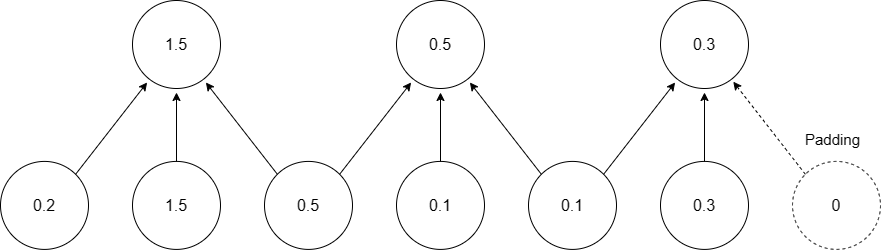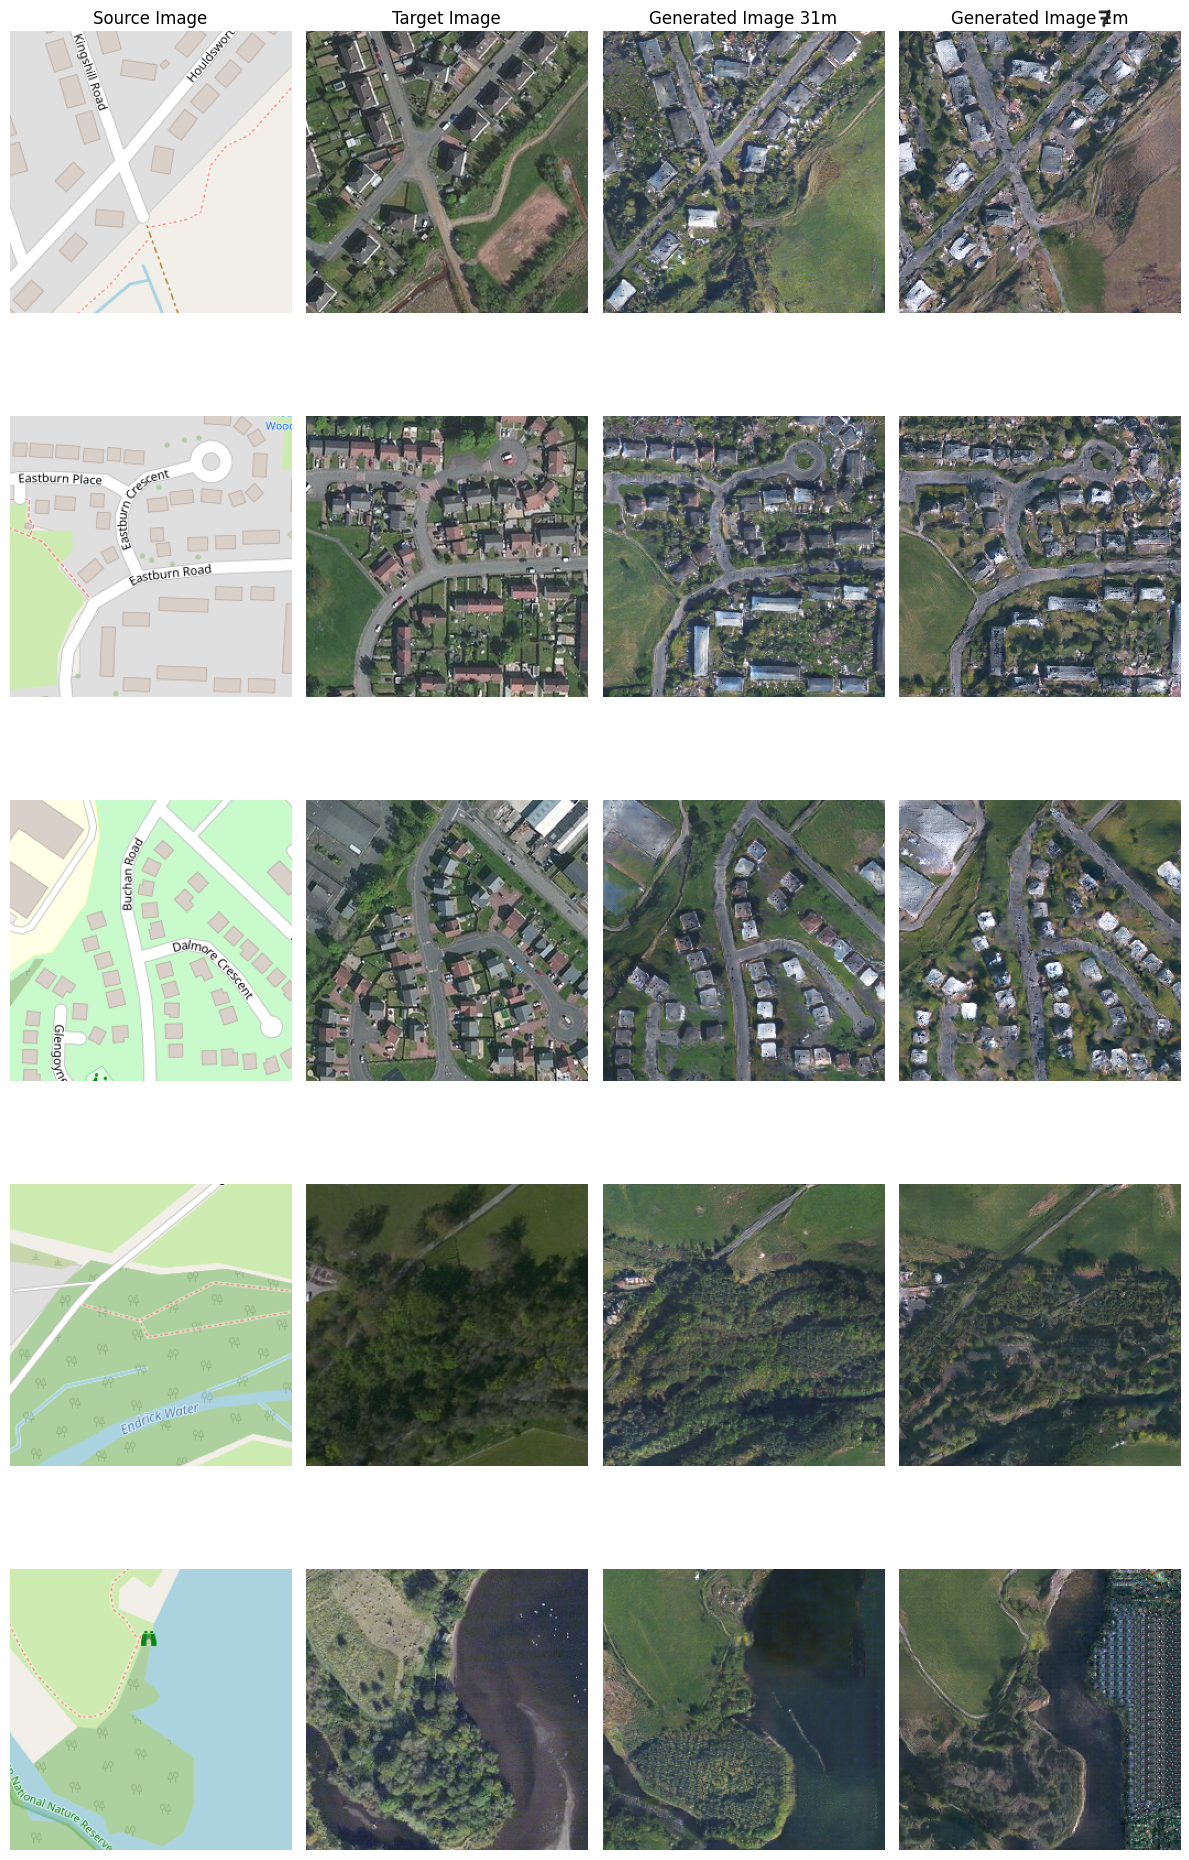)

### **Network Architectures:**
#### **Generator:**
Two generator architectures were explored in this study. In both cases i created a UNet composed of an Encoder, a Bottleneck, and a Decoder. Skip connections (by channel concatenation) establish a direct link between corresponding layers in the encoder and decoder. More precisely, a layer in the encoder is linked to the layer in the decoder that is at the same "level" or depth in the network. This connection skips the intermediate layers and enables direct information flow between the encoding and decoding stages. Two "sizes" of the UNet were trained and tested, a *Small Generator* with 7 million parameters, and secondly, a *Big Generator* with 31 million parameters. The bottleneck of the UNet had 512 and 1024 channels, respectively. You can intend the SmallGen as a trimmed version of the BigGen missing the deepest layer, therefore having the bottleneck on "level" above. The encoder part exploited a convolutional block made of Conv -> ReLU -> Conv -> ReLU, and then a MaxPooling operation for down-sampling, while the Decoder used Transposed Convolutions for up-sampling and again the convolutional block for feature extraction before each up-sampling. The output layer used a 1x1 convolution to transform the 64 channels into the 3 RGB channels.
#### **Discriminator:**
The Discriminator is a way simpler net, thought not to be very powerful to permit the generator to learn in the early stages. Four strided convolution blocks, with stride=2, were employed along with LeakyReLU and Instance Normalization. Only the first layer missed the Instance Norm., as good pratice teaches, allowing the net to possibly learn the real image scaling. The shape of the image were therefore halved at each layer while the number of feature maps were doubled. A last output conv. layer with linear activation was used to generate the "patched" result, a 8x8 matrix indicating the probability of each of the 64 patches of the paired (OSM + Satellite) input image to be a **real** pair.
You can check the code for all the detailed architectures and parameters.


### **Cascade Style Method:**
Additionally, a cascade-style method was implemented, involving the training of a *Refinement Network*. This network takes, as input, the output of the initial generator (which transforms map images into satellite images) and refines it to enhance realism. The Refinement Network is still a Gan and shares the same architecture as the Big Generator, but with a slightly modified Loss Function coming from an original Idea, propertly designed for the task. This cascade approach aims to iteratively improve the quality of generated satellite views. Initially, a ResNet autoencoder with no adversarial training was tested, with terrible results, thus it was discarded.

### **Datasets:**
Two datasets were utilized for training and evaluation purposes. The first dataset comprised 50,000 images of the central belt of Scotland and was used to train and evaluate both Small and Big Generators. It had the problem to be biased towards green areas, such as fields and forests, since this region of scotland is mostly rural. For this reasons another Dataset was created involing a more urban area, with a greater balance between city landscape and the natural world. This second dataset included 10,000 images of the city of Edinburgh. Data augmentation by rotation was applied to this set. It was used to train the Big Generator and the Refinement Network. The images were originally of size 256x256 but i decided to resize them to 128x128 by interpolation for computational purposes. Thus, the Generators input and output were of shape 3x128x128 while the discriminator input of shape 6x128x128 since it combined both OSM and Satellite view to decide if the Sat image was real or fake according to the corresponding OSM.


### **Loss Functions:**
The loss function for the original GANs (Small and Big Generators) is a combination of adversarial loss, ensuring realistic output, and a weighted L1-loss, which enforced pixel-wise similarity between the generated and real target images. The Generator then minimizes:

### $$ \mathcal{L}_{G} = BCE [\, D(x,G(x))\, , \, \mathbf{1}\,] + λ·L1(\,y,\, G(x))$$

where L1 is the pixel-wise Mean Absolute Error between the generated image and real target:
#### $$ L_1(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^{n} \left| \hat{y}_i - y_i \right| $$
The lambda λ parameter was set to 100, as the authors of the original papers found it to be a good value. I personally tried to increase this parameter for the latest epochs to try to fine-grain the generation towards the real targets, but not significant results were noticed.

Regarding the discriminator loss, it requires the network to "see" both a real source-target image pair, and a source-fake image pair. The patches of the real couple needs to be classify as 1s, while of the fake couple as 0. The Discriminator then minimizes:

### $$ \mathcal{L}_{D} = BCE[\, D(x,y)\, , \,  \mathbf{1}\,] + BCE[\, D(x,G(x))\, , \,  \mathbf{0}\,] $$
With $\mathbf{1}$ and $\mathbf{0}$ being matrices full of 1s or 0s with the same shape of the discriminator output.

The *Refinement Network*, introduces an extra term to its generator loss function. In addition to adversarial and L1-loss, it includes a term that represents the negative L1 between the generated image and the input image. The intution is that the input image comes from the previous generator that reached a minima, and hence it would be hard for the new discriminator to overcome the limitation of the previous one (they also have the same architecure). This negative term aims to encourage divergence from the input, preventing the network from outputting an identity transformation, pushing the network to produce a different representation while still approaching the real target, improving the quality of the input image. I personally had this idea and tried it out:

### $$ \mathcal{L}_{RefG} = BCE [\, D(x,G(x))\, , \, \mathbf{1}\,] + λ·L1(\,y,\, G(x)) - α · L1(x, G(x)) $$

I set α = 10 as an hyperparameter. I've also trained this net with the original unmodified loss (α = 0) for comparison between the two methods.

### **Training:**
#### **Central Belt Dataset:**
SmallGen, BigGen, and both Discriminators,
* **Optimizer:** Adam
* **Learning Rate:** 0.0001
* **Epochs:** 600
* **LR-scheduler**: divided by 10 at epoch 480
* **Batch Size:** 16
* **λ:** 100

#### **Edinburgh City Dataset:**
BigGen, RefinementNet
* **Epochs**: 700
* **α:** 10
* **Data Agumentation:** Rotation by 90, 180, 270 degrees (1 to 4 images)
* **Others**: same as above

I followed the various trainings by printing the losses each 10 batches, and by showing 6 source, target and corresponding generated images every 10 epochs, in order to visualize the quality of the creations. In this way i was able to discard *malfunctioning* hyperparameters and architectural variations in real-time, by spotting mode collapses (generated images all similar and completely noisy) and vanishing gradients (Discriminator loss very close to zero). With this experience, as the theory confirm, I could notice that the training was stable when the discriminator loss stays around 0.5 with minor fluctations. You can check the code for a partial output printed in console, with losses and images. I also saved a full checkpoint of the models, optimizer and losses every epoch.


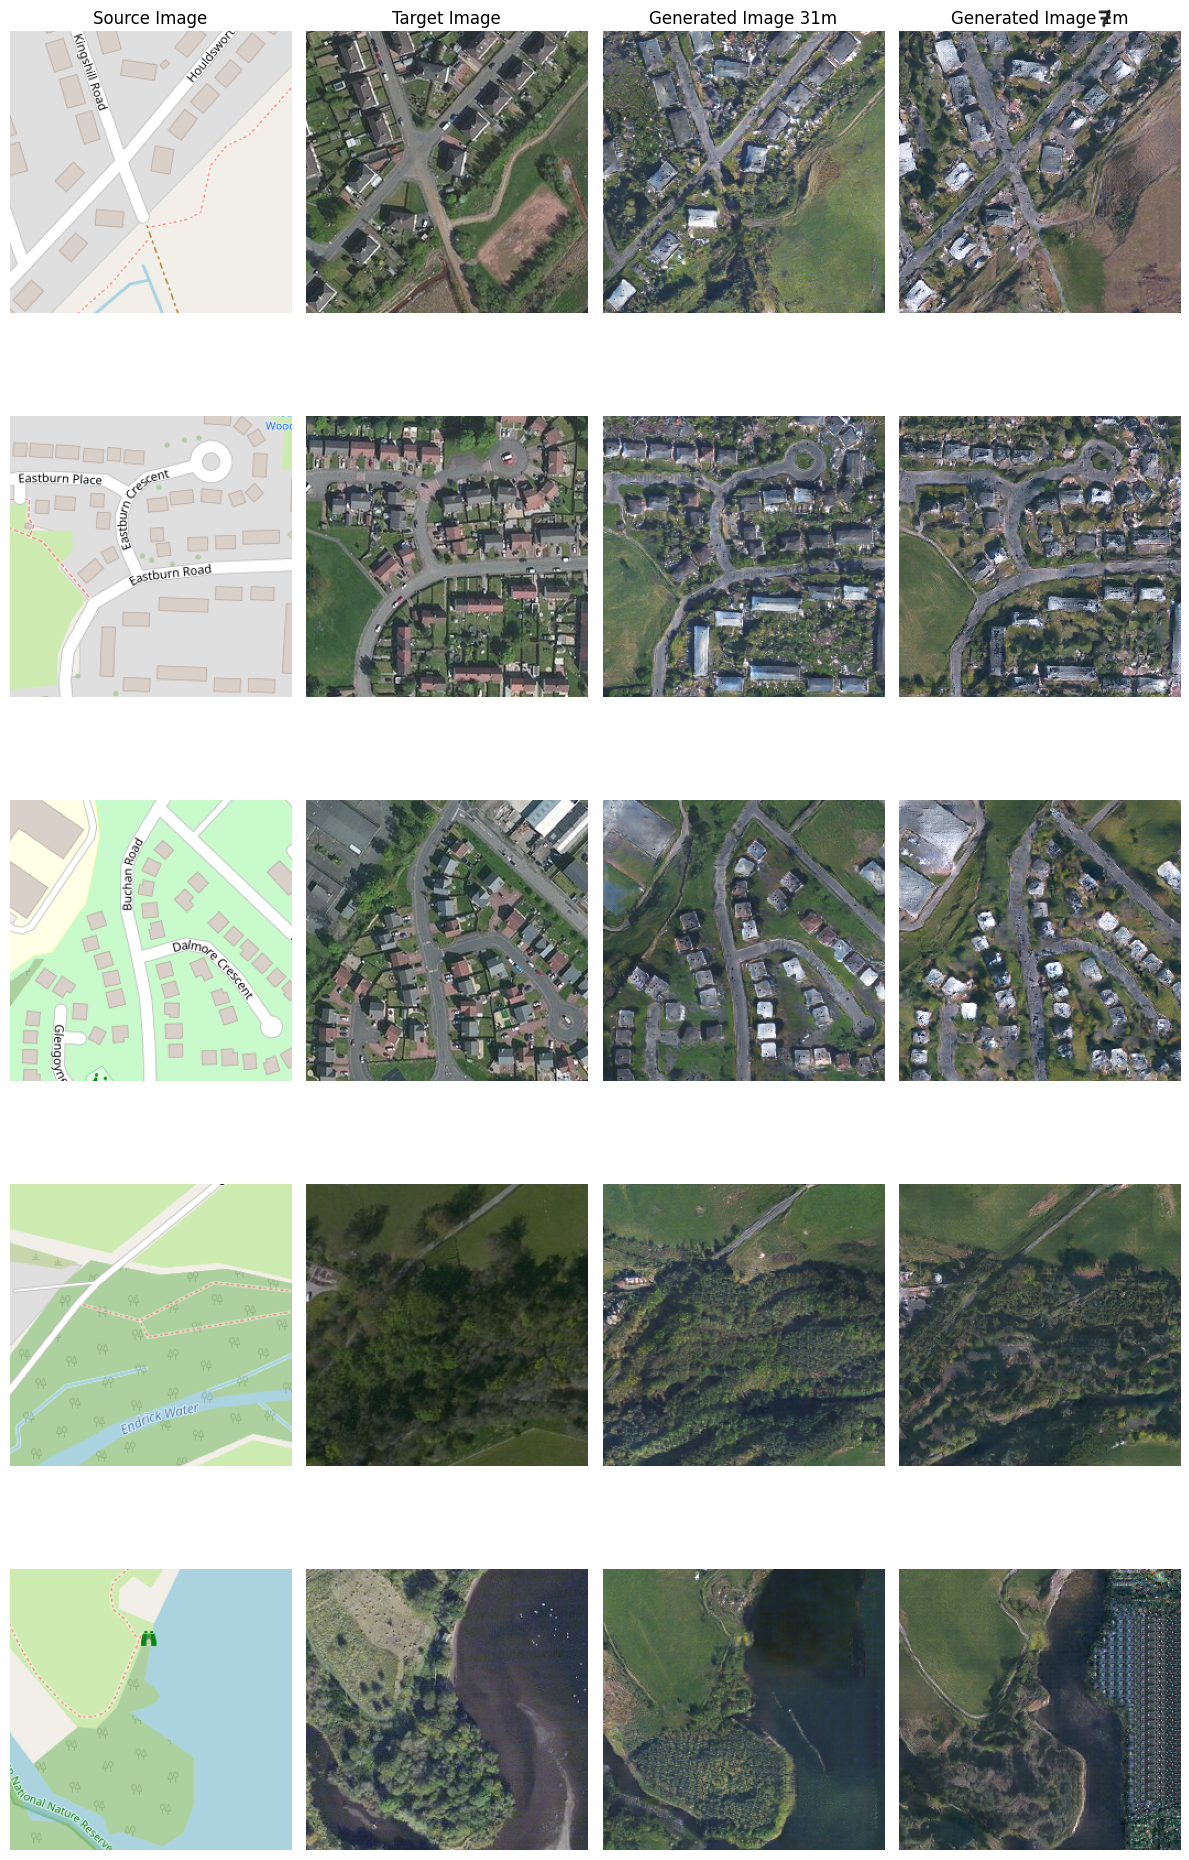